In [1]:
import torch

In [2]:
from torchvision import transforms

data_dir = './fellowshipai/102flowers'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
pip install scipy


[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
from torch.utils.data import Dataset
from scipy.io import loadmat
from PIL import Image
import os 


class FlowersDataset(Dataset):
    def __init__(self, root_dir, mat_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.labels = loadmat(mat_file)['labels'][0]
        self.image_files = sorted([f for f in os.listdir(root_dir) if f.endswith('.jpg')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        label = self.labels[idx] - 1# Adjust labels to start from 0

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
data_dir = './fellowshipai/102flowers/'
mat_file = './fellowshipai/imagelabels.mat'

In [6]:
dataset = FlowersDataset(data_dir, mat_file, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size]
)

In [7]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [8]:
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
import numpy as np

model = resnet50(weights=ResNet50_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False


num_classes = len(np.unique(dataset.labels))
model.fc = nn.Linear(model.fc.in_features, num_classes)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)


In [9]:
from torch import optim


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [10]:
num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    accuracy = 100 * correct / total
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%')

Epoch [1/10], Train Loss: 2.7161, Val Loss: 1.5551, Accuracy: 81.81%
Epoch [2/10], Train Loss: 1.0032, Val Loss: 0.8614, Accuracy: 90.60%
Epoch [3/10], Train Loss: 0.5463, Val Loss: 0.6394, Accuracy: 92.00%
Epoch [4/10], Train Loss: 0.3560, Val Loss: 0.5247, Accuracy: 93.10%
Epoch [5/10], Train Loss: 0.2565, Val Loss: 0.4512, Accuracy: 93.83%
Epoch [6/10], Train Loss: 0.1912, Val Loss: 0.3982, Accuracy: 93.59%
Epoch [7/10], Train Loss: 0.1492, Val Loss: 0.3580, Accuracy: 93.77%
Epoch [8/10], Train Loss: 0.1187, Val Loss: 0.3501, Accuracy: 94.26%
Epoch [9/10], Train Loss: 0.0945, Val Loss: 0.3253, Accuracy: 94.14%
Epoch [10/10], Train Loss: 0.0808, Val Loss: 0.3121, Accuracy: 94.63%


In [11]:
pip install matplotlib


[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [14]:
class_names = [f'Class {i}' for i in range(num_classes)]  # Replace with actual class names if available

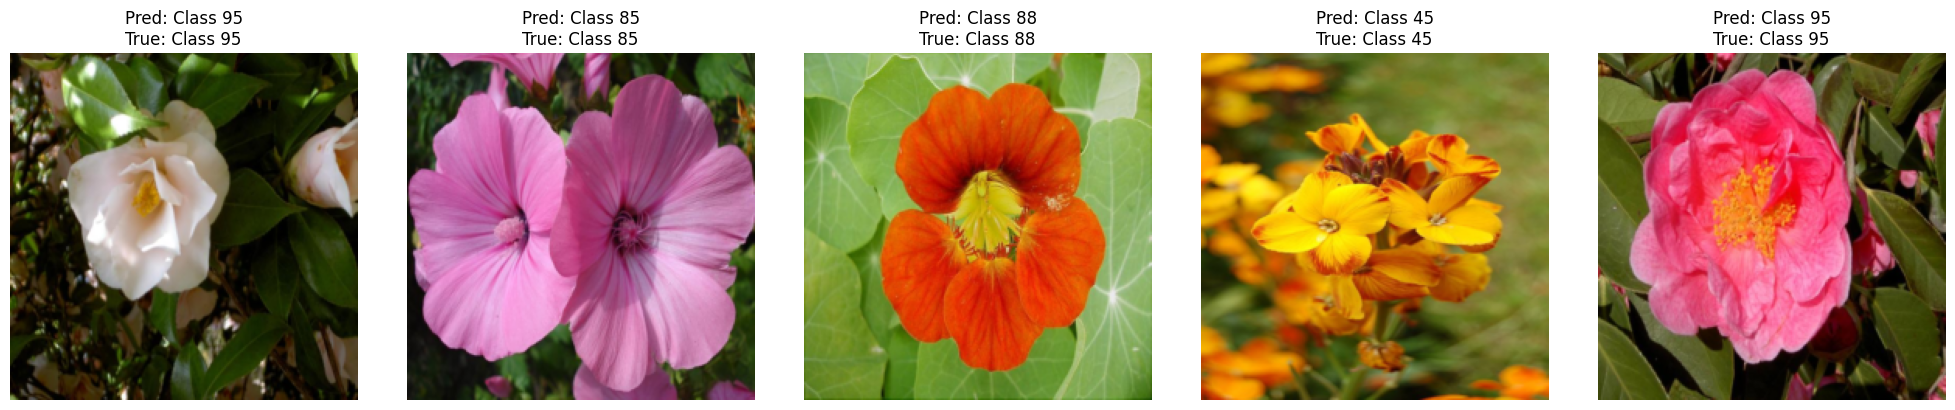

In [15]:
import matplotlib.pyplot as plt


def show_sample_predictions(model, data_loader, class_names, num_samples=5):
    model.eval()
    fig, axs = plt.subplots(1, num_samples, figsize=(20, 4))
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loader):
            if i == num_samples:
                break
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            img = inputs[0].cpu().permute(1, 2, 0)
            img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
            img = img.numpy()
            img = np.clip(img, 0, 1)
            
            axs[i].imshow(img)
            axs[i].set_title(f'Pred: {class_names[preds[0]]}\nTrue: {class_names[labels[0]]}')
            axs[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# After training
show_sample_predictions(model, val_loader, class_names)

In [18]:
def predict_image(model, image_path, class_names):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    
    return class_names[predicted.item()]

# Test on a new image
new_image_path = './fellowshipai/image.jpg'
prediction = predict_image(model, new_image_path, class_names)
print(f'Predicted class: {prediction}')

Predicted class: Class 93
